In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as spectra_utils
import analyze_tools.monte_carlo as atm

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

"""
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
"""
plt.rcParams.update({'font.size': 12})


Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [2]:
s = red.sigma_Ar_Xe
e = red.epsilon_Ar_Xe

re = s * 2 ** (1/6)
k = 4 * e * (156 * (s**12 / re**14) - 42 * (s**6 / re**8))
mu = red.mass_dict['Ar'] * red.mass_dict['Xe'] / (red.mass_dict['Ar'] + red.mass_dict['Xe'])
omega = np.sqrt(k / mu)

vib_freq = omega / (2 * np.pi * red.c * red.sigma)
vib_freq

22.766978335022763

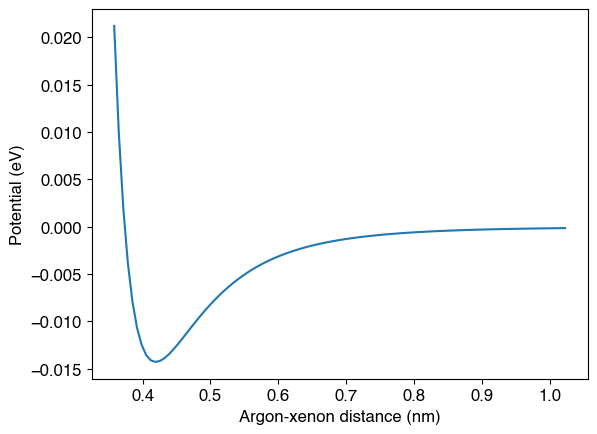

In [3]:
potential_function = lambda r:  4 * red.epsilon_Ar_Xe \
            * ( (red.sigma_Ar_Xe/r)**12 - (red.sigma_Ar_Xe/r)**6 )

fig,ax = plt.subplots()

R = np.linspace(1.05,3,100)
ax.plot(
    R * red.sigma * 1e7, 
    red.convert_energy(potential_function(R),'ev')
)
ax.set_xlabel('Argon-xenon distance (nm)')
ax.set_ylabel('Potential (eV)')
fig.savefig('potential.jpeg',dpi = 600)

In [ ]:
fig.show()

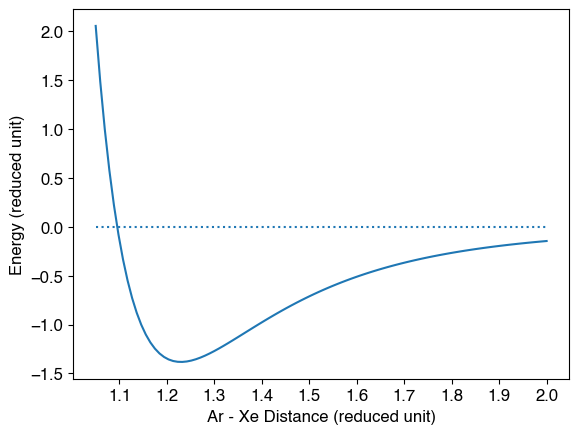

In [4]:
potential_function = lambda r:  4 * red.epsilon_Ar_Xe \
            * ( (red.sigma_Ar_Xe/r)**12 - (red.sigma_Ar_Xe/r)**6 )

fig,ax = plt.subplots()

r = np.linspace(1.05, 2.0, 100)
ax.plot(r, potential_function(r))
ax.hlines(0, min(r), max(r), linestyle = 'dotted')

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xlabel('Ar - Xe Distance (reduced unit)')
ax.set_ylabel('Energy (reduced unit)')

fig.savefig('figure/potential.jpeg',dpi = 600)

#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0:
            r0 = np.zeros(3)
        else:
            r0 = np.hstack(
                [
                    #np.random.uniform(-Lxy/2+10, Lxy/2-10, size = 2), 
                    np.zeros(2),
                    np.random.uniform(-Lz/2+10, Lz/2-10)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = at.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [5]:
##################################
#"""
#Single pair of Ar-Xe
#Single mode @ resonance
#Examining the coupling strength
#"""
##################################

single_mode_result_dict = {}

for i, ct in enumerate([1, 10,20,40]):
    
    atoms = get_ArXePair(1.2, n_pairs = 1)
    
    field = get_field(mode = 23, coup_str = ct * Lxy, amplitude = 'zero', T = 0)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    single_mode_result_dict.update({ct: rd})
    

In [ ]:
import importlib
spectra_utils = importlib.reload(spectra_utils)

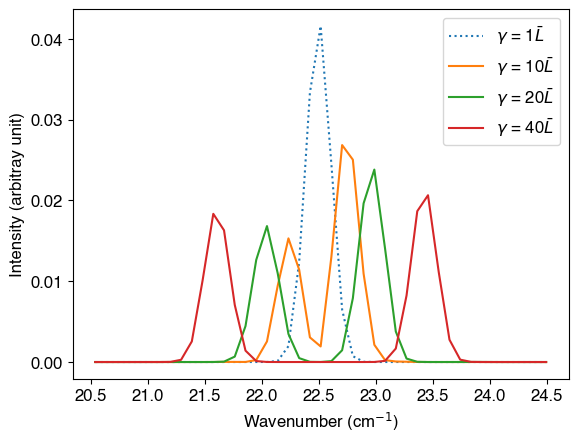

In [9]:
fig,ax = plt.subplots()

for ct, rd in single_mode_result_dict.items():
    
    dipole_spectra = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})
    dipole_spectra.add_result_dict(rd)
    wn, ir = dipole_spectra()

    ir = np.sum(ir, axis = 0)
    ir = ir[(wn < 24.5) * (wn > 20.5)]
    wn = wn[(wn < 24.5) * (wn > 20.5)]
    
    ax.plot(
        wn, ir, label = r"$\gamma$ = {}".format(ct) + r"$\bar{L}$",
        linestyle = 'dotted' if ct == 1 else None
    )

"""
for ct, rd in multimode_result_dict.items():
    
    dipole_spectra = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})
    dipole_spectra.add_result_dict(rd)
    wn, ir = dipole_spectra()

    ir = np.sum(ir, axis = 0)
    ir = ir[(wn < 27) * (wn > 18)]
    wn = wn[(wn < 27) * (wn > 18)]
    
    ax[1].plot(
        wn, ir, label = r"$\gamma$ = {}L".format(ct),
        linestyle = 'dotted' if ct == 1 else None
    )
"""

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax.set_ylabel('Intensity (arbitray unit)')
#ax[1].set_ylabel('Intensity (arbitray unit)')
ax.legend()

fig.savefig('figure/manuscript/polariton.jpeg',dpi=600, bbox_inches = 'tight')

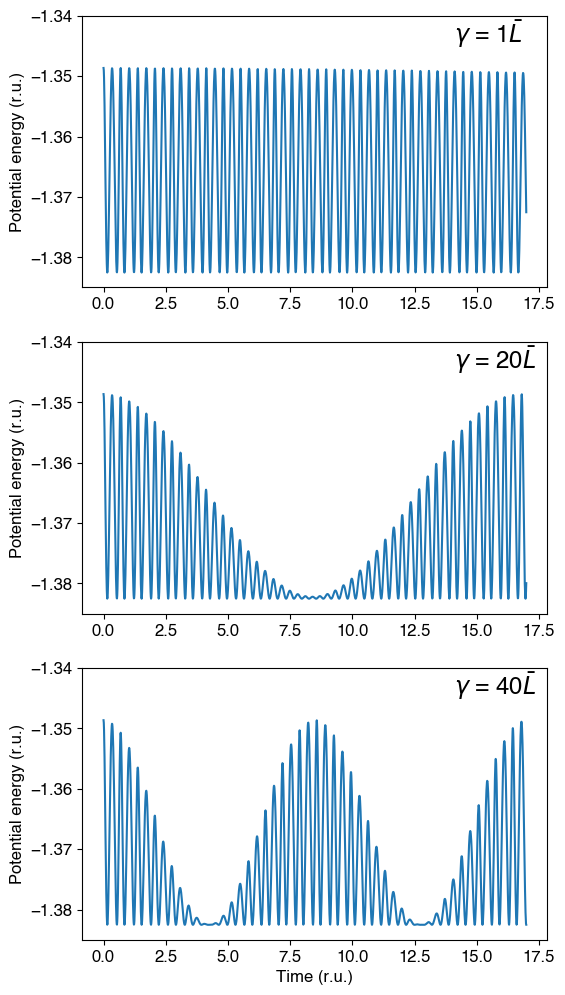

In [11]:
fig, ax = plt.subplots(3, figsize = (6,12))

for i,k in enumerate([1, 20, 40]):
    R = single_mode_result_dict[k]['atoms'].trajectory['r']
    time = single_mode_result_dict[k]['atoms'].trajectory['t']
    
    def get_potential(array):
        d = array[0] - array[1]
        d = np.sqrt(np.sum(d * d))
        return potential_function(d)
    
    D = list(map(lambda array: get_potential(array), R))
    
    ax[i].plot(time[:1700], D[:1700])
    ax[i].set_ylim(-1.385, -1.34)

    ax[i].annotate(
        r'$\gamma$ = {}'.format(k) + r'$\bar{L}$',
        xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
    ax[i].set_ylabel('Potential energy (r.u.)')

ax[i].set_xlabel('Time (r.u.)')

fig.savefig('figure/SI/harmonic_analysis.jpeg', dpi = 600, bbox_inches = 'tight')

In [ ]:
multimode_result_dict

In [ ]:
atoms = multimode_result_dict[20]['atoms']

fig,ax = plt.subplots()

ax.plot(
    atoms.observable['t'][:20000], 
    atoms.observable['potential'][:20000]
)
ax.set_xlabel('Time (r.u.)')
ax.set_ylabel('Potential energy (r.u.)')

fig.savefig('figure/presentation/weak potential.jpeg',dpi = 600, bbox_inches='tight')

In [ ]:
atoms = single_mode_result_dict[40]['atoms']

fig,ax = plt.subplots()

ax.plot(
    atoms.observable['t'][:1500], 
    atoms.observable['potential'][:1500]
)
ax.set_xlabel('Time (r.u.)')
ax.set_ylabel('Potential energy (r.u.)')
fig.savefig('figure/presentation/strong potential.jpeg',dpi = 600, bbox_inches='tight')

In [ ]:
Lxy

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the coupling strength
"""

multimode_result_dict = {}

for i, ct in enumerate([1, 10,20,40]):
    
    atoms = get_ArXePair(1.2, n_pairs = 1)
    
    field = get_field(mode = list(range(1,261)), coup_str = ct * Lxy, amplitude = 'zero', T = 0)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 20000, verbose = False)

    multimode_result_dict.update({ct: rd})
    
    

In [ ]:
""
Single pair of Ar-Xe
Single mode @ resonance
Examining the Ar-Xe initial distance
"""
single_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 23, coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    single_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in single_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000))
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 100) * (wn > 0)]
        wn = wn[(wn < 100) * (wn > 0)]
    else: 
        i = 0
        ir = ir[(wn < 45) * (wn > 18)]
        wn = wn[(wn < 45) * (wn > 18)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/single_distance.jpeg',dpi=600)

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the Ar-Xe initial distance
"""
multi_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 'multi', coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    multi_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in multi_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000), quant = 'dipole_velocity')
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    else: 
        i = 0
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/multi_distance.jpeg',dpi=600)

In [ ]:
"""
Multiple pair of Ar-Xe
Single mode @ resonance
Examining the coupling strength
"""

single_mode_atoms_dict = {}

np.random.seed(100)

for i, n_pairs in enumerate([1,5,10]):
    
    atoms = get_ArXePair(1.2, n_pairs = n_pairs)
    
    field = get_field(mode = 23, coup_str = 20 * Lxy, amplitude = 'zero', T = 0)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    single_mode_atoms_dict.update({n_pairs: rd})

In [ ]:
fig,ax = plt.subplots(3)

for i, (n_pairs, rd) in enumerate(single_mode_atoms_dict.items()):
    #if ct == 5:continue
    dipole_spectra = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})
    dipole_spectra.add_result_dict(rd)
    wn, ir = dipole_spectra()
    
    ir = np.sum(ir, axis = 0)
    ir = ir[(wn < 40) * (wn > 10)]
    wn = wn[(wn < 40) * (wn > 10)]
    
    ax[i].plot(
        wn, ir, label = "{} complexes".format(n_pairs),
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.savefig('figure/multicomplex_single.jpeg',dpi=600)

In [ ]:
atoms = single_mode_atoms_dict[5]
dpv = np.array(atoms.observable['dipole_velocity'])

i = 7
single_dpv = dpv[:,2*i,:] + dpv[:,2*i+1,:]
time = atoms.observable['t']

wn, ir = fft_autocorr(time, single_dpv, 1e-2, windows = 'BH')

fig,ax = plt.subplots()

ax.plot(wn,ir)
ax.set_xlim(10,30)

In [ ]:
%reset -f